# Recommendation using Collaborative Filtering

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

## Data input

In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('/home/user/Documents/ml-100k/u.data', sep='\t', names=header)

In [3]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items) ) 

Number of users = 943 | Number of movies = 1682


In [4]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.25)

/home/user/myenv2/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [5]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))

for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]
    

## Similarity Calculation

In [14]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1-pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = 1-pairwise_distances(train_data_matrix.T, metric='cosine')
x=pd.DataFrame(user_similarity)
sim_mat=x[12].copy()
sim_mat.sort(inplace=True,ascending=False)

/home/user/myenv2/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



## Heat Map of Similarities

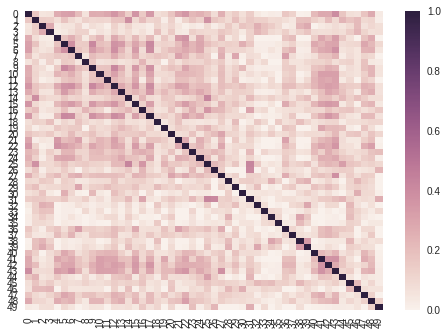

In [7]:
seaborn.heatmap(user_similarity[0:50,0:50])
plt.show()

## Prediction Algorithm 

In [8]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff)/np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [9]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return prediction

## Error Calculation

In [15]:
err = abs(user_prediction[test_data_matrix.nonzero()] - test_data_matrix[test_data_matrix.nonzero()])

## Histogram of Errors

In [17]:
data = [go.Histogram(
    x = err
)]
layout = go.Layout(
    title='Histogram of Errors ',
    xaxis=dict(
        title='error'
    ),
    yaxis=dict(
        title='count'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic histogram')